In [2]:
import torch
from matplotlib import pyplot as plt
from models.cnp import CNP
from models.wta_cnp import WTA_CNP

In [3]:
root_path = "/home/yigit/projects/mbcnp/outputs/baxter/"
suffix = '7D'
run_id, model_folder = f'{suffix}/1704193118', '/saved_models/'
models_path = f'{root_path}{run_id}{model_folder}'

cnp_model_path, wta_model_path = f'{models_path}cnp_on_synth.pt', f'{models_path}wta_on_synth.pt'

raw_data_path = '/home/yigit/projects/mbcnp/data/baxter/231229/'

In [4]:
y = torch.load(f'{root_path}{run_id}/y.pt').cpu()
num_samples, t_steps, dy = y.shape

x = torch.linspace(0, 1, 200).repeat(num_samples, 1).view(num_samples, -1, 1)
colors = ['tomato', 'aqua', 'limegreen', 'gold', 'mediumslateblue', 'lightcoral', 'darkorange', 'teal']

from matplotlib import pyplot as plt

fig, axs = plt.subplots(dy, 1, figsize=(7, 25))
for i in range(num_samples):
    for j in range(dy):
        axs[j].plot(x[i, :, 0].cpu(), y[i, :, j].cpu(), label=f'Demonstration {i+1}')
        axs[j].grid(True)
        axs[j].legend()

        axs[j].set_xlabel('Time (t)')
        axs[j].set_ylabel('SM(t)')
        axs[j].set_title(f'DoF #{j+1}')

plt.tight_layout()
plt.savefig(f'{raw_data_path}data_{suffix}.png')
plt.close()

In [5]:
batch_size = 7
cnp = CNP(input_dim=1, hidden_dim=158, output_dim=dy, n_max_obs=6, n_max_tar=6, num_layers=3, batch_size=batch_size)
wta = WTA_CNP(1, dy, 6, 6, [128, 128, 128], num_decoders=2, decoder_hidden_dims=[128, 128, 128], batch_size=batch_size)

cnp.load_state_dict(torch.load(cnp_model_path))
wta.load_state_dict(torch.load(wta_model_path))

cnp.eval()
wta.eval()

WTA_CNP(
  (encoder): Sequential(
    (0): Linear(in_features=8, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoders): ModuleList(
    (0-1): 2 x Sequential(
      (0): Linear(in_features=129, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=14, bias=True)
    )
  )
  (gate): Sequential(
    (0): Linear(in_features=128, out_features=2, bias=True)
    (1): Softmax(dim=-1)
  )
)

In [6]:
import os
import csv

def get_batch(idx=[0, -1], cond_idx=[0]):

    batch_obs = torch.zeros(batch_size, len(cond_idx), dy+1)
    batch_obs[:, :, 0] = x[0, cond_idx, 0]

    raw_data = []
    for demo_file in sorted(os.listdir(raw_data_path)):
        if demo_file.endswith('.csv'):
            d = os.path.join(raw_data_path, demo_file)

            temp_data = []
            
            with open(d, 'r') as f:
                for i, line in enumerate(csv.reader(f)):
                    if i > 0:
                        temp_data.append([float(line[-7]), float(line[-6]), float(line[-5]), float(line[-4]), float(line[-3]), float(line[-2]), float(line[-1])])

            raw_data.append(temp_data)

    demonstration = []
    for i in range(len(raw_data)):
        traj = raw_data[i]
        processed_traj = []
        inds = torch.linspace(0, len(traj)-1, t_steps, dtype=int)
        for ind in inds:
            processed_traj.append(traj[ind])

        demonstration.append(processed_traj)

    batch_y = torch.tensor(demonstration, dtype=torch.float32)

    batch_obs[:, :, 1:] = batch_y[idx, cond_idx, :].view(batch_size, len(cond_idx), dy)
    # for i in range(batch_size):
    #     batch_obs[i, 0, 0] = x[i, cond_idx[0], 0]
    #     batch_obs[i, 0, 1:] = batch_y[i, cond_idx[0], :]
    return batch_obs, batch_y[idx, :, :]




In [7]:
# obs = torch.Tensor([1.0, 0.0]).unsqueeze(0).unsqueeze(0)
test_ind = 0
# obs = torch.zeros(batch_size, 1, 1+dy)
# for i in range(batch_size):
#     obs[i, 0, 0] = x[i, test_ind, 0]
#     obs[i, 0, 1:] = y[i, test_ind, :]

# real_y = y

tar = torch.linspace(0, 1, 200).unsqueeze(0).unsqueeze(-1).repeat(batch_size, 1, 1)
# print(obs.shape, tar.shape)

obs, real_y = get_batch(list(range(7)), [test_ind])

print(obs.shape, real_y.shape, tar.shape)

with torch.no_grad():
    pred_cnp, _ = cnp(obs, tar)
    pred_wta, gate = wta(obs, tar)


# print(obs)
print(pred_wta.shape, pred_cnp.shape, gate.shape, real_y.shape)
# print(gate)

torch.Size([7, 1, 8]) torch.Size([7, 200, 7]) torch.Size([7, 200, 1])
torch.Size([2, 7, 200, 14]) torch.Size([7, 200, 14]) torch.Size([7, 1, 2]) torch.Size([7, 200, 7])


In [8]:
def save_trajs_to_file():
    with open(f'{root_path}{run_id}/res_wta.txt', 'w') as f:
        for i in range(batch_size):
            best = torch.argmax(gate[i, 0, :]).item()  # best decoder
            for j in range(t_steps):
                for k in range(dy):
                    f.write(f'{pred_wta[best, i, j, k].item()} ')
                f.write('\n')
            f.write('\n\n\n')

    with open(f'{root_path}{run_id}/res_cnp.txt', 'w') as f:
        for i in range(batch_size):
            for j in range(t_steps):
                for k in range(dy):
                    f.write(f'{pred_cnp[i, j, k].item()} ')
                f.write('\n')
            f.write('\n\n\n')

    with open(f'{root_path}{run_id}/real.txt', 'w') as f:
        for i in range(num_samples):
            for j in range(t_steps):
                for k in range(dy):
                    f.write(f'{y[i, j, k].item()} ')
                f.write('\n')
            f.write('\n\n\n')

    with open(f'{root_path}{run_id}/obs.txt', 'w') as f:
        for i in range(batch_size):
            for j in range(dy):
                f.write(f'{obs[i, 0, j+1].item()} ')
            f.write('\n\n')

save_trajs_to_file()

# NOW go to baxter sim to generate cartesian trajectories

469 0.5601831108978361 -0.33438703088084226
451 0.5600910053668992 -0.3640876978217442
443 0.5602558452103172 -0.3791593152832171
392 0.7224116606722957 -0.4796689537280607


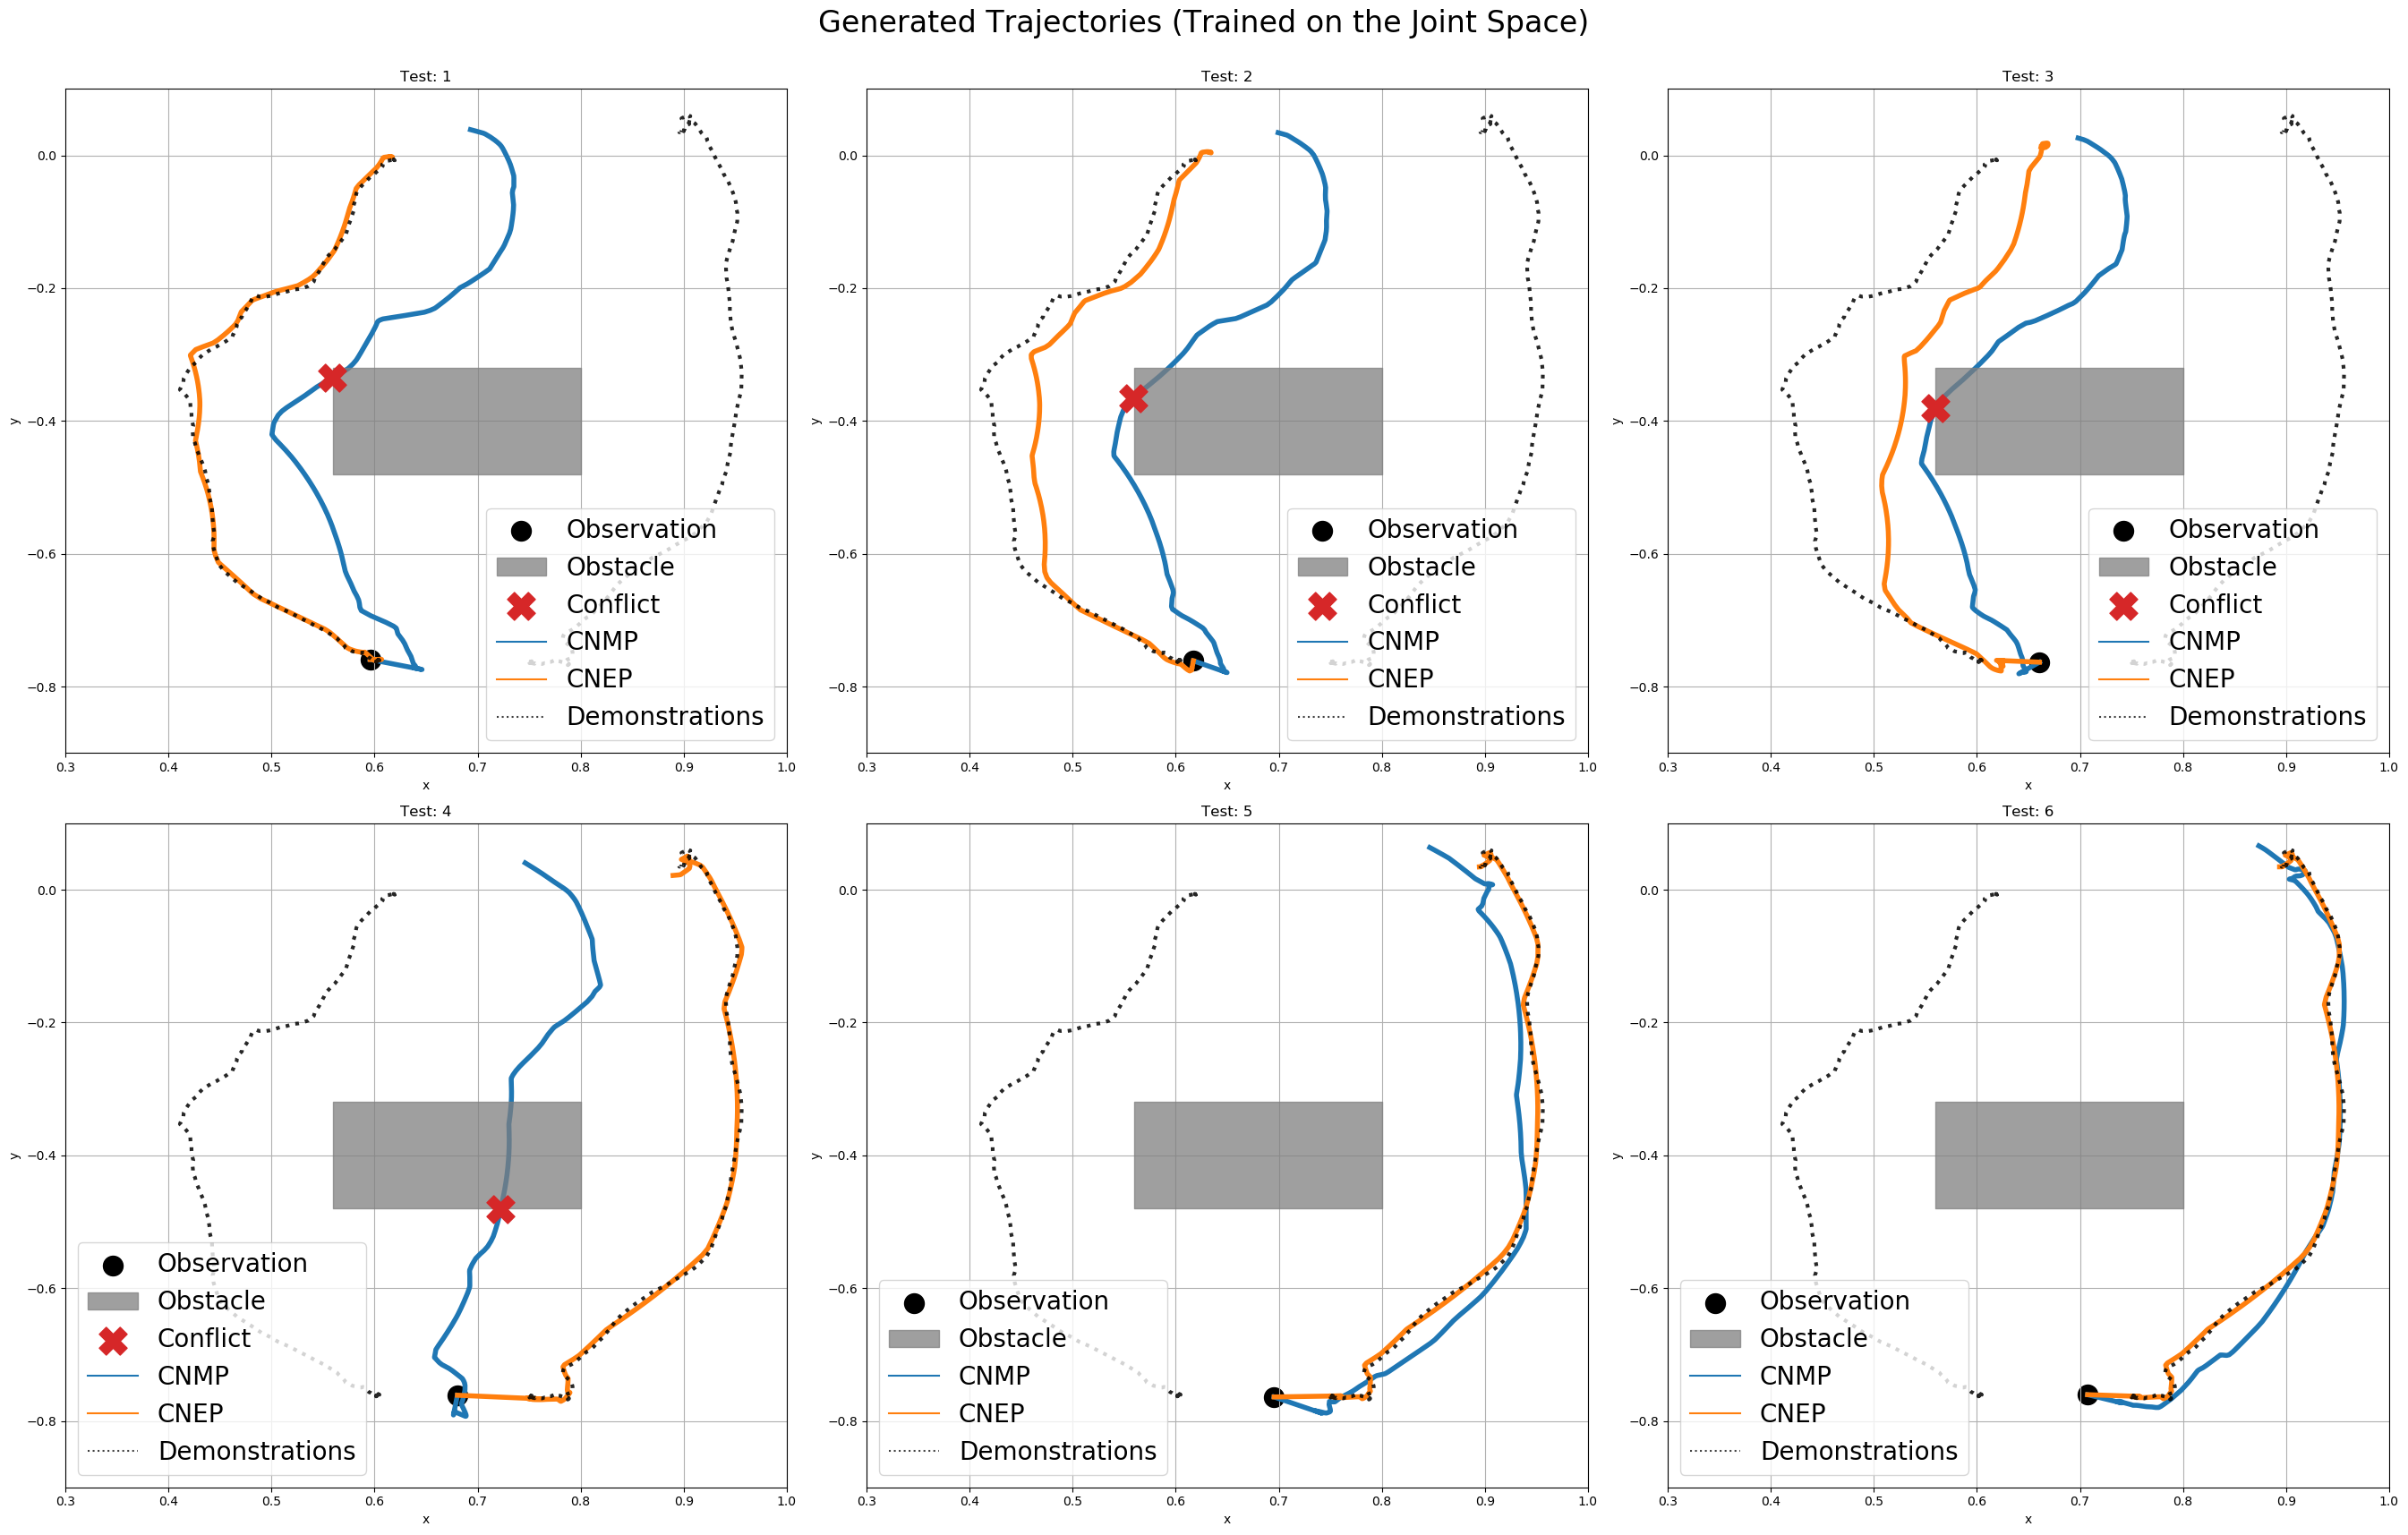

In [9]:
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns
import csv
import scipy.interpolate as interp


palette = sns.color_palette("tab10")

def plot_cnp_wta_dim():
    rows, cols = torch.floor(torch.sqrt(torch.tensor(batch_size))).int(), torch.ceil(torch.sqrt(torch.tensor(batch_size))).int()
    ax_rows, ax_cols = rows.item()*dy, cols.item()  # 7, 2
    fig, axs = plt.subplots(ax_rows, ax_cols, figsize=(12, 12))
    for i in range(ax_rows):  # 7
        for j in range(ax_cols):  # 2
            axs[i, j].scatter(obs[j, :, 0], obs[j, :, i+1], label='Observation', c='k')
            # axs[i, j].set_ylim((plt_y_lower_lim, plt_y_upper_lim))
            axs[i, j].plot(x[j], real_y[j,:,i], 'k--', alpha=0.75, label='Query trajectory')  # data
            
            axs[i, j].plot(x[j], pred_cnp[j,:,i], 'b', alpha=0.5)  # cnp predictions

            handles = axs[i, j].get_legend_handles_labels()[0]
            handles.extend([Line2D([0], [0], label='CNMP', color='b')])

            best = torch.argmax(gate[j, 0, :]).item()
            for k in range(gate.shape[-1]):
                axs[i, j].plot(x[j], pred_wta[k,j,:,i], colors[k%batch_size], alpha=max(0.2, gate[j, 0, k].item()))  # wta predictions
                if k==best:
                    handles.extend([Line2D([0], [0], label=f'CNEP-{k}: {gate[j, 0, k].item():.4f}', color=colors[k])])

            axs[i, j].plot(x[j], y[j,:,i], 'k--', alpha=0.35, label='demo_traj_0')  # data
            axs[i, j].plot(x[j], y[1-j,:,i], 'k--', alpha=0.35, label='demo_traj_1')  # data
            handles.extend([Line2D([0], [0], label='demo_traj_0', alpha=0.35, color='k')])
            handles.extend([Line2D([0], [0], label='demo_traj_1', alpha=0.35, color='k')])

            axs[i, j].legend(handles=handles, loc='best')
            axs[i, j].set_title(f'Demo: {j+1}, Dim: {i+1}')
            axs[i, j].grid(True)


def determine_subplot_index(i, j, ax_rows):
    if ax_rows == 1:
        return j
    else:
        return i, j
    
def plot_gen_cnp_wta():
    pred_cnp, pred_wta, y_cartesian, obs_cartesian = get_pred_cartesian()

    rows, cols = torch.floor(torch.sqrt(torch.tensor(batch_size))).int(), torch.ceil(torch.sqrt(torch.tensor(batch_size))).int()
    ax_rows, ax_cols = rows.item(), cols.item()  
    fig, axs = plt.subplots(ax_rows, ax_cols, figsize=(ax_cols*9, ax_rows*9))
    for i in range(ax_rows):
        for j in range(ax_cols):
            ind = i*ax_cols + j

            subplot_index = determine_subplot_index(i,j,ax_rows)

            axs[subplot_index].scatter(obs_cartesian[ind, 0, 0], obs_cartesian[ind, 0, 1], label='Observation', c='k')
            
            axs[subplot_index].plot(pred_cnp[ind,:,0], pred_cnp[ind,:,1], color=palette[0], label='CNMP', alpha=1)  # cnp predictions
            axs[subplot_index].plot(pred_wta[ind,:,0], pred_wta[ind,:,1], color=palette[1], label='CNEP', alpha=1)  # cnp predictions

            handles = axs[subplot_index].get_legend_handles_labels()[0]
            handles.extend([Line2D([0], [0], label='CNMP', color=palette[0])])

            axs[subplot_index].plot(pred_wta[ind, :, 0], pred_wta[ind, :, 1], color=palette[1], linewidth=4.0)  # wta predictions
            handles.extend([Line2D([0], [0], label=f'CNEP', color=palette[1])])

            axs[subplot_index].plot(y_cartesian[0,:,0], y_cartesian[0,:,1], 'k:', alpha=0.75)  # data
            axs[subplot_index].plot(y_cartesian[1,:,0], y_cartesian[1,:,1], 'k:', alpha=0.75)  # data
            handles.extend([Line2D([0], [0], label='Demonstrations', alpha=0.75, color='k', linestyle='dotted')])

            axs[subplot_index].legend(handles=handles, loc='lower left')
            axs[subplot_index].set_title(f'Test: {ind+1}')
            axs[subplot_index].grid(True)
            axs[subplot_index].set_xlabel('x')
            axs[subplot_index].set_ylabel('y')
            

    # plt.savefig(f'{root_path}{run_id}/gen.png')
    plt.show()

def get_pred_cartesian():
    # load generated trajectories from npy files
    pred_cnp = torch.from_numpy(np.load(f'{root_path}{run_id}/gen_cnp.npy'))
    pred_wta = torch.from_numpy(np.load(f'{root_path}{run_id}/gen_wta.npy'))
    y_cartesian = torch.from_numpy(np.load(f'{root_path}{run_id}/gen_real.npy'))
    obs_cartesian = torch.from_numpy(np.load(f'{root_path}{run_id}/gen_obs.npy'))

    batch_size = pred_cnp.shape[0]//t_steps
    assert pred_cnp.shape[0] == pred_wta.shape[0] == batch_size*t_steps

    pred_cnp = pred_cnp.view(batch_size, t_steps, dy)
    pred_wta = pred_wta.view(batch_size, t_steps, dy)
    y_cartesian = y_cartesian.view(-1, t_steps, dy)
    obs_cartesian = obs_cartesian.view(-1, 1, dy)

    return pred_cnp, pred_wta, y_cartesian, obs_cartesian


def pid_control(conditioning_point, trajectory, kp=0.5, ki=0.1, kd=0.05, decay_steps=10):
    # Convert inputs to numpy arrays for easier handling
    cond = np.array(conditioning_point).squeeze()
    traj = np.array(trajectory)
    
    # Initialize correction terms
    integral = np.zeros(2)  # Integral term for x and y
    derivative = np.zeros(2)  # Derivative term for x and y
    
    # Set the initial error based on the conditioning point
    error = traj[0] - cond
    last_error = error.copy()

    # Apply PID control to each point in the trajectory
    for t in range(len(traj)):
        p_term = kp * error
        
        # Integral term based on the sum of past errors
        integral += error
        i_term = ki * integral
        if t > 0:  # Skip the first timestep to avoid undefined derivative
            derivative = error - last_error
        d_term = kd * derivative
        correction = p_term + i_term + d_term
        decay_factor = (1 - t / decay_steps) if t < decay_steps else 0
        correction *= decay_factor
        traj[t] += correction
        last_error = error.copy()
        
        if t < len(traj) - 1:
            error = traj[t + 1] - traj[t]
    
    # Ensure the trajectory starts exactly at the conditioning point
    traj[0] = cond

    return traj


def process_trajs(pred_cnp, pred_wta, y_cartesian, obs_cartesian):
    demo_file = f'{raw_data_path}used/01.csv'
    demo_data = []

    #read into demo_data
    with open(demo_file, 'r') as f:
        csv_reader = csv.reader(f)
        
        for i, line in enumerate(csv_reader):
            if i > 0:
                line_flt = [float(x) for x in line]
                if line_flt[-8] > 0.0:  # gripper closed
                    demo_data.append(np.array(line_flt))
            else:
                header = line

    demo_data = np.array(demo_data)
    
    num_tests = obs_cartesian.shape[0]

    # interpolate pred_cnp and pred_wta using demo_data as length
    start, end = demo_data[0][0], demo_data[-1][0]
    len_traj = pred_cnp.shape[1]
    x = np.linspace(start, end, len_traj)

    post_c, post_w = np.zeros((num_tests, len(demo_data[:, 0]), 2)), np.zeros((num_tests, len(demo_data[:, 0]), 2))
    for i in range(num_tests):
        fx = interp.interp1d(x, pred_wta[i, :, 0])
        fy = interp.interp1d(x, pred_wta[i, :, 1])

        wta_interp, cnp_interp = np.zeros((len(demo_data[:, 0]), 2)), np.zeros((len(demo_data[:, 0]), 2))
        wta_interp[:, 0] = fx(demo_data[:, 0])
        wta_interp[:, 1] = fy(demo_data[:, 0])

        fx = interp.interp1d(x, pred_cnp[i, :, 0])
        fy = interp.interp1d(x, pred_cnp[i, :, 1])
        
        cnp_interp[:, 0] = fx(demo_data[:, 0])
        cnp_interp[:, 1] = fy(demo_data[:, 0])

        # pid-control
        post_w[i] = pid_control(obs_cartesian[i, :, 0:2].cpu().numpy(), wta_interp)  # 1:3 because 1:x, 2:y
        post_c[i] = pid_control(obs_cartesian[i, :, 0:2].cpu().numpy(), cnp_interp)


    return post_c, post_w


def plot_cnp_wta_xy(pred_cnp, pred_wta, y_cartesian, obs_cartesian):
    rows, cols = torch.floor(torch.sqrt(torch.tensor(batch_size))).int(), torch.ceil(torch.sqrt(torch.tensor(batch_size))).int()
    ax_rows, ax_cols = rows.item(), cols.item()  
    fig, axs = plt.subplots(ax_rows, ax_cols, figsize=(ax_cols*9, ax_rows*9))
    test_id = 0

    for i in range(ax_rows):
        for j in range(ax_cols):

            ind = i*ax_cols + j

            if ind >= 2:
                ind += 1

            subplot_index = determine_subplot_index(i,j,ax_rows)
            axs[subplot_index].set_xlim((0.3, 1.0))
            axs[subplot_index].set_ylim((-0.9, 0.1))

            axs[subplot_index].scatter(obs_cartesian[ind, :, 0], obs_cartesian[ind, :, 1], label='Observation', c='k', s=250.0)

            x1, x2, y1, y2 = 0.56, 0.8, -0.48, -0.32
            axs[subplot_index].fill_between([x1, x2], y1, y2, color=palette[7], label='Obstacle', alpha=0.75, zorder=5)
            if ind==0 or ind==1 or ind==3 or ind==4:
                for cind in range(pred_cnp.shape[1]):
                    if x1<=pred_cnp[ind, cind, 0]<=x2 and y1<=pred_cnp[ind, cind, 1]<=y2:
                        break
            
                axs[subplot_index].scatter(pred_cnp[ind, cind-1, 0], pred_cnp[ind, cind-1, 1], label='Conflict', color=palette[3], marker='X', s=500.0, zorder=6)
                print(cind, pred_cnp[ind, cind, 0], pred_cnp[ind, cind, 1])
            
            axs[subplot_index].plot(pred_cnp[ind, :, 0], pred_cnp[ind, :, 1], color=palette[0], linewidth=4.0)  # cnp predictions

            handles = axs[subplot_index].get_legend_handles_labels()[0]
            handles.extend([Line2D([0], [0], label='CNMP', color=palette[0])])

            axs[subplot_index].plot(pred_wta[ind, :, 0], pred_wta[ind, :, 1], color=palette[1], linewidth=4.0)  # wta predictions
            handles.extend([Line2D([0], [0], label=f'CNEP', color=palette[1])])

            axs[subplot_index].plot(y_cartesian[0,:,0], y_cartesian[0,:,1], 'k:', alpha=0.85, linewidth=3.0)  # data
            axs[subplot_index].plot(y_cartesian[1,:,0], y_cartesian[1,:,1], 'k:', alpha=0.85, linewidth=3.0)  # data
            handles.extend([Line2D([0], [0], label='Demonstrations', alpha=0.75, color='k', linestyle='dotted')])

            lloc = 'lower right' if ind < 4 else 'lower left'

            axs[subplot_index].legend(handles=handles, loc=lloc, fontsize=20)
            axs[subplot_index].set_title(f'Test: {test_id+1}')
            axs[subplot_index].grid(True)
            axs[subplot_index].set_xlabel('x')
            axs[subplot_index].set_ylabel('y')
            test_id += 1

    fig.suptitle(f'Generated Trajectories (Trained on the Joint Space)', fontsize=24)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f'{root_path}{run_id}/gen.png')
    plt.show()


# plot_gen_cnp_wta()

prec, prew, yc, oc = get_pred_cartesian()
c, w = process_trajs(prec, prew, yc, oc)
plot_cnp_wta_xy(c, w, yc, oc)

In [9]:
torch.isclose(pred_cnp[0], pred_cnp[1])


tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])